<a href="https://colab.research.google.com/github/SourLemon23/lung-cancer-diagnosis/blob/master/lung_cancer_diagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [536]:
import os
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Dense, Flatten, Dropout
import matplotlib.pyplot as plt

In [537]:
! pip install efficientnet
import efficientnet.tfkeras as efn

In [538]:
# Authorize access to mount Google Drive 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [539]:
# Initialize dataset directories (Google Drive)
training_dir   = r'/content/drive/My Drive/Colab Notebooks/Lung Cancer Diagnosis/lung_cancer_image_set/Training'
validation_dir = r'/content/drive/My Drive/Colab Notebooks/Lung Cancer Diagnosis/lung_cancer_image_set/Validation'
testing_dir    = r'/content/drive/My Drive/Colab Notebooks/Lung Cancer Diagnosis/lung_cancer_image_set/Testing'

In [540]:
# Store all testing images in a list
testing_img_paths = []

for root, dirs, files in os.walk(testing_dir):
    for filename in files:
        testing_img_paths.append(os.path.abspath(os.path.join(root, filename)))

# Randomize the list
random.shuffle(testing_img_paths)

In [541]:
# Initialize constants
classes = ['adenocarc', 'normal', 'squamous']
img_width, img_height = 180, 180
target_size = (img_width, img_height)
input_shape = (img_width, img_height, 3)

testing_set_start_index = -50
testing_set_end_index = 49

batch_size = 50
epochs = 5

In [542]:
# Augment data
training_data_gen = ImageDataGenerator(rescale=1./255,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       zoom_range=0.15,
                                       shear_range=0.15,
                                       rotation_range=360,
                                       width_shift_range=0.15,
                                       height_shift_range=0.15,
                                       validation_split=0.15)

validation_data_gen = ImageDataGenerator(rescale=1./255)

testing_data_gen = ImageDataGenerator(rescale=1./255)

In [543]:
# Split data
training_generator = training_data_gen.flow_from_directory(training_dir,
                                                           target_size=target_size,
                                                           class_mode='categorical',
                                                           batch_size=batch_size,
                                                           shuffle=True)

validation_generator = validation_data_gen.flow_from_directory(validation_dir,
                                                               target_size=target_size,
                                                               class_mode='categorical',
                                                               batch_size=batch_size,
                                                               shuffle=False)

testing_generator = testing_data_gen.flow_from_directory(testing_dir,
                                                         target_size = target_size,
                                                         class_mode='categorical',
                                                         batch_size=batch_size,
                                                         shuffle=True)

Found 14409 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
Found 301 images belonging to 3 classes.


In [544]:
# Create a neural network
def create_model():
    model = efn.EfficientNetB4(weights='imagenet', include_top=False, input_shape=input_shape)
    
    x = model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation="relu")(x)
    x = Dense(64, activation="relu")(x)
    predictions = Dense(training_generator.num_classes, activation="softmax")(x)
    model = Model(inputs=model.input, outputs=predictions)

    return model

In [545]:
# Print an overall summary of the model
def print_model_summary(model):
    model.summary()

In [546]:
# Configure model
def compile_model(model):
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [547]:
# Train the model
def fit_model(model):
    history = model.fit(training_generator,
                        epochs=epochs,
                        steps_per_epoch=(training_generator.n/batch_size),
                        validation_data=validation_generator,
                        validation_steps=(validation_generator.n/batch_size))
    
    return history

In [548]:
# Plot and evaluate the model
def evaluate_model(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

In [549]:
# Randomly pick and display an unseen image for the network to predict
def select_testing_image():
    image_num = random.randint(testing_set_start_index, testing_set_end_index)
    testing_img = testing_generator[0][0][image_num]

    class_num = np.argmax(testing_generator[0][1][image_num])
    true_label = classes[class_num].capitalize()

    print(f'True Label: {true_label}')

    return testing_img

In [550]:
# Classify a tumor from an MRI scan
def classify_tumor(model, testing_img):      
    img_array = img_to_array(testing_img)
    img_array = img_array.reshape(-1, img_width, img_height, 3)

    predictions = model.predict(img_array)
    class_num = predictions.argmax()

    network_percent_confidence = str(np.max(predictions) * 100)[:4] + '%'
    network_prediction = classes[class_num].capitalize()

    font = {'family': 'DejaVu Sans',
            'color' : 'red',
            'weight': 'heavy',
            'size'  :  10}
    
    plt.imshow(testing_img)
    plt.title(f'Network Prediction: {network_prediction} ({network_percent_confidence})', fontdict=font) 

In [551]:
model = create_model()
compile_model(model)
print_model_summary(model)

Model: "functional_51"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 90, 90, 48)   1296        input_29[0][0]                   
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 90, 90, 48)   192         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 90, 90, 48)   0           stem_bn[0][0]                    
______________________________________________________________________________________

Epoch 1/5
289/288 [==============================] - 278s 961ms/step - loss: 0.1400 - accuracy: 0.9498 - val_loss: 0.4734 - val_accuracy: 0.9367
Epoch 2/5
289/288 [==============================] - 275s 950ms/step - loss: 0.0421 - accuracy: 0.9854 - val_loss: 0.0150 - val_accuracy: 0.9933
Epoch 3/5
289/288 [==============================] - 276s 954ms/step - loss: 0.0534 - accuracy: 0.9830 - val_loss: 0.4787 - val_accuracy: 0.8800
Epoch 4/5
289/288 [==============================] - 275s 953ms/step - loss: 0.0258 - accuracy: 0.9908 - val_loss: 0.0160 - val_accuracy: 0.9900
Epoch 5/5
289/288 [==============================] - 276s 955ms/step - loss: 0.0184 - accuracy: 0.9938 - val_loss: 0.0048 - val_accuracy: 0.9967


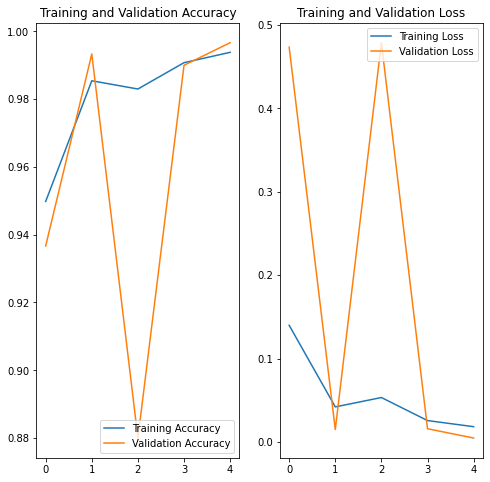

In [552]:
history = fit_model(model)
evaluate_model(history)

True Label: Adenocarc


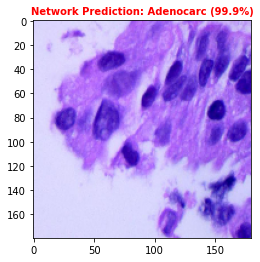

In [553]:
testing_img = select_testing_image()
classify_tumor(model, testing_img)